In [1]:
## Import packages ##
## Data Structures 
import pandas as pd
import numpy as np

## Graphing 
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Models 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## Scoring measures 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# Ignore these annoying warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define plotting functions to be used later 
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

In [4]:
train_df = pd.read_csv("train.csv") # Load the data 
train_df.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


# EDA

In [5]:
train_df.shape

(5500, 23)

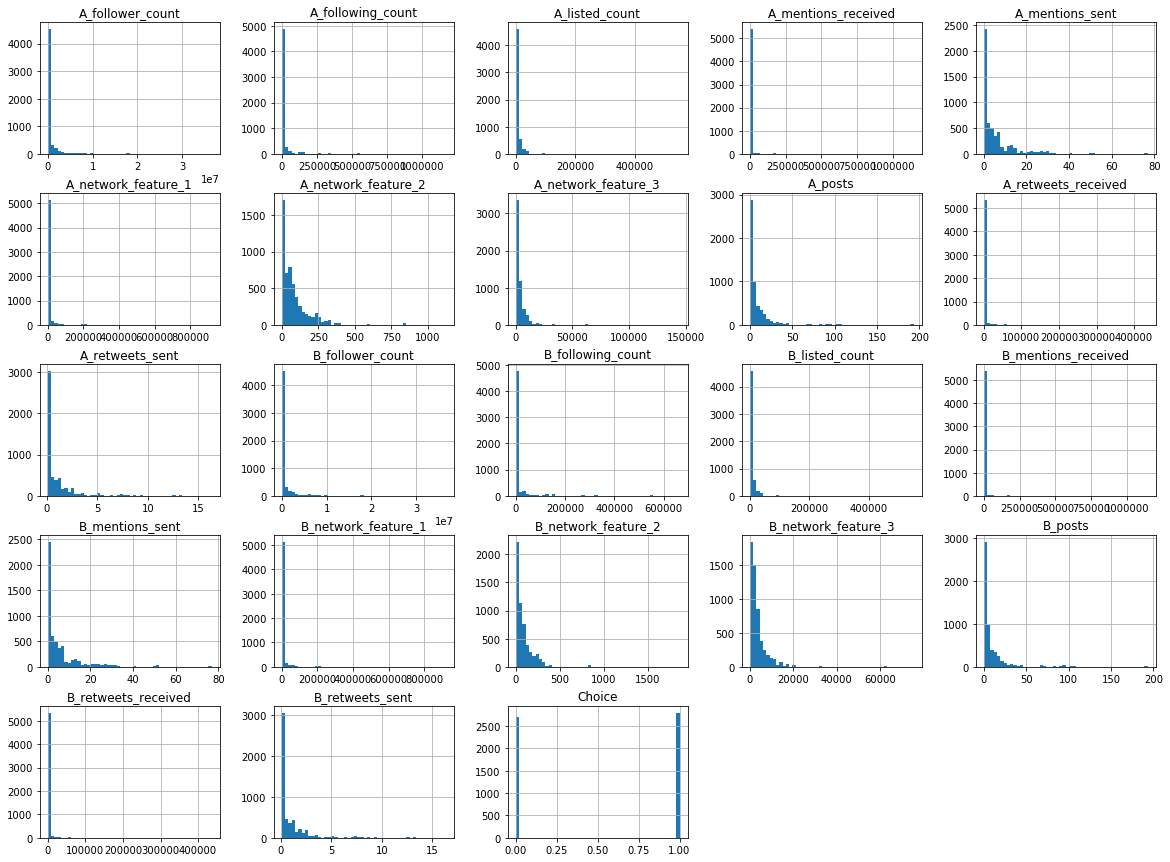

In [6]:
train_df.hist(bins=50, figsize=(20,15))
plt.show()

All data very skewed, need to normalize 

In [7]:
from pandas.tools.plotting import scatter_matrix 

# attributes = ['A_network_feature_2', 'B_network_feature_2', 'A_mentions_sent', 'B_mentions_sent']
# scatter_matrix(train_df[attributes], figsize=(12, 8))
# plt.show()

In [8]:
## Get a count of Null values for each column 
for col in list(train_df):
    num_null = train_df[col].isnull().sum()
    if num_null > 0:
        print(col, num_null, str(num_null/train_df.shape[0]*100)+'%')
# No Nulls!

# Data Pre-Processing

In [9]:
# Split data into target and rest of data
X = train_df.drop('Choice', axis=1)
y = train_df['Choice'].copy()

In [10]:
# Shuffle into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Running Models

# SGD Classifier

In [12]:
sgd_clf = SGDClassifier(random_state=41)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=41, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.72091131, 0.6810415 , 0.67237164])

In [14]:
## Much better way to look at classifier performence is with a confusion matrix 

## First we need a set of predicitons

from sklearn.model_selection import cross_val_predict #note this is different from cross_val_score

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [15]:
confusion_matrix(y_train, y_train_pred)
## Each row represents an ACTUAL CLASS
## Each columns represents a PREDICTED CLASS
## In this example:
## [0,0] = True Negatives
## [0,1] = False Positives
## [1,0] = False Negatives
## [1,1] = True Positives

## Note: indexing goes like [row, column]

array([[1228,  574],
       [ 563, 1320]], dtype=int64)

In [16]:
## Lets look at precision and recall:

## Precision = TP / (TP + FP)
## Recall = TP / (TP + FN)

from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)
#When it claims A is the influencer, it is only correct 56.02% of the time **UNSCALED**
#When it claims A is the influencer, it is only correct 69.69% of the time **SCALED**

0.6969376979936642

TRY THIS:

maybe we want to maximize precision?  If we can detect with higher accuracy when A is an influencer, then we also get higher accuracy of when B is an influencer

In [17]:
recall_score(y_train, y_train_pred)
#It only detects 70% of the A influencers

0.7010090281465746

In [18]:
## Typically we will want to use an F1 score to compare classifiers 
## F1 score is the harmonic mean of precision and recall

# from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

## F1 score favors models that have similiar recall and precision 
## This may not always be the case (sometimes only care about one)

## Cannot have both ways - increasing precision reduces recall, and vice-versa
## This iss called the precision/recall tradeoff

0.6989674344718031

In [19]:
## How do we decide what threshold to use?  
## To do this, we first need to get scores of all instances in the training data again,
## but this time retunr decision scores instead of predicitons 

y_scores = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, method='decision_function')

In [20]:
## Now we can compute precision and recall for all possible thresholds using sklearn package 

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

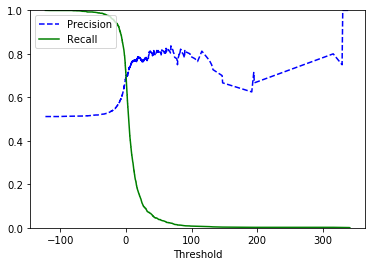

In [21]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
## Now lets look at the receiver operating characteristic (ROC) curve
## ROC plots true positive rate (recall) vs. false positive rate (FPR)
## The FPR is the ratio of negative instances that are incorrectly classified as positive
## FPR = 1 - TNR (true negative rate)
## True negative rate is also called specificity 

## To plot ROC curve, we first need to calculate TPR and FPR for many threshold values

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

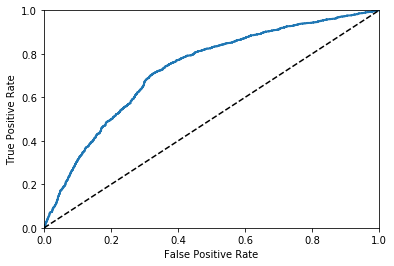

In [23]:
plot_roc_curve(fpr,tpr)
plt.show()

In [24]:
# from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.7300252920134176

Thats a pretty poor curve.

Let's try using random forest to classify 

# Random Forest

In [25]:
## Lets try running a RandomForest and see the PR and ROC AUC curves
## NOTE: RandomForestClassifier does not have decision_function(); instead it has predict_proba()

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')

In [26]:
y_probas_forest
## Row per instance
## Column per class
## each containing the prob that the given instances belongs to the given class

array([[0.3, 0.7],
       [0. , 1. ],
       [0.1, 0.9],
       ...,
       [1. , 0. ],
       [0.8, 0.2],
       [0. , 1. ]])

In [27]:
## But to plot a ROC curve we need scores, not probabilities
## To fix this we use the psoitive class's probability as the score:

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, trp_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

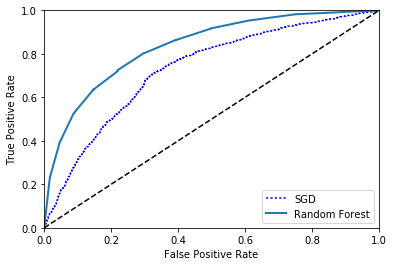

In [28]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest, trp_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [29]:
roc_auc_score(y_train, y_scores_forest)

0.8342279746997348

In [30]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
precision_score(y_train, y_train_pred_forest)

0.7755681818181818

In [31]:
recall_score(y_train, y_train_pred_forest)

0.724907063197026

In [32]:
f1_score(y_train, y_train_pred_forest)

0.7493823771616799

Better!  But we can likely do even better than this with more data pre-processing.  Let's take a look at the attriubte importance.

In [33]:
attribs_list = list(X_train)

forest_clf.fit(X_train, y_train)

fi = sorted(zip(forest_clf.feature_importances_, attribs_list), reverse=True)
fi

[(0.0806952214207121, 'A_listed_count'),
 (0.07974526376552896, 'A_follower_count'),
 (0.07971251457812156, 'B_listed_count'),
 (0.0778636036513697, 'B_network_feature_1'),
 (0.06960952679523, 'A_retweets_received'),
 (0.05930215229213289, 'B_mentions_received'),
 (0.05811247527480008, 'A_network_feature_1'),
 (0.05492866457241317, 'B_retweets_received'),
 (0.047270370236004285, 'B_follower_count'),
 (0.047168416258084316, 'A_mentions_received'),
 (0.03614681141942456, 'A_following_count'),
 (0.03227892045794395, 'B_following_count'),
 (0.03120583318475368, 'A_network_feature_2'),
 (0.03119033279104832, 'A_network_feature_3'),
 (0.03067912390157332, 'B_mentions_sent'),
 (0.03063720743637912, 'A_posts'),
 (0.029908697420772838, 'B_network_feature_3'),
 (0.02926882154851146, 'B_posts'),
 (0.02835596604779562, 'B_network_feature_2'),
 (0.026959559885129315, 'A_mentions_sent'),
 (0.01987725497578207, 'A_retweets_sent'),
 (0.019083262086488716, 'B_retweets_sent')]

In [34]:
cross_val_score(forest_clf, X_test, y_test, cv=3, scoring='accuracy')

array([0.76072607, 0.76363636, 0.74668874])

# Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error 

## implement early stopping by actually stopping training early (instead of a large number of trees first
## and then looking back to find the optimal number)

## This can be accomplished by setting warm_start=True -- allows for incremental learning 
## The following code stsops straining when the validation error does not improve for 5 iterations in a row 

gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators # The number of boosting stages to perform 
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0 
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping 

n_estimators, min_val_error

(12, 0.2721763085399449)

In [36]:
gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=12)
gbrt_best.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=12,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [37]:
cross_val_score(gbrt_best, X_test, y_test, cv=3, scoring='accuracy')

array([0.74917492, 0.77024793, 0.78476821])

Boosting has best accuracy so far!

# Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

cross_val_score(log_reg, X_test, y_test, cv=3, scoring='accuracy')

array([0.72277228, 0.74545455, 0.74503311])

In [39]:
# Feel free to expand upon logistic regression

# Summary of Accuracy Scores

In [40]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
gbrt_clf = GradientBoostingClassifier(max_depth=2, n_estimators=12)
sgd_clf = SGDClassifier()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('grbt',gbrt_clf),
                                         ('sgd', sgd_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [41]:
# Hard-voting
for clf in (log_reg, rnd_clf, svm_clf, gbrt_clf, sgd_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7515151515151515
RandomForestClassifier 0.771900826446281
SVC 0.5173553719008265
GradientBoostingClassifier 0.7669421487603306
SGDClassifier 0.7068870523415978
VotingClassifier 0.7823691460055097


In [42]:
## If all the classifiers in the ensemble are able to predict probabilities, then you can tle scikit learn to 
## predict the class with the highest class probability, averaged over all the individual classifiers 
## This is called *soft voting* - all you have to do is replace voting='hard' with voting='soft'


log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
gbrt_clf = GradientBoostingClassifier(max_depth=2, n_estimators=12, random_state=42)

# svm_clf_soft = SVC(probability=True, random_state=42) #Need probability=True for SVC to output a predict_proba method
# Take svm out since it seems to adversly affect soft voting 
# sgd_clf = SGDClassifier(random_state=42) # cant get it to work with soft voting 


voting_clf_soft = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('grbt',gbrt_clf)], voting='soft')

voting_clf_soft.fit(X_train, y_train)


for clf in (log_reg, rnd_clf, gbrt_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7515151515151515
RandomForestClassifier 0.7680440771349862
GradientBoostingClassifier 0.7669421487603306
VotingClassifier 0.7707988980716254


In [43]:
y_probas_voting = cross_val_predict(voting_clf_soft, X_train, y_train, cv=3, method='predict_proba')
y_probas_voting

array([[0.40638088, 0.59361912],
       [0.17417058, 0.82582942],
       [0.31187963, 0.68812037],
       ...,
       [0.76778841, 0.23221159],
       [0.43983999, 0.56016001],
       [0.16369693, 0.83630307]])

In [44]:
y_scores_voting = y_probas_voting[:, 1] # score = proba of positive class
fpr_voting, trp_voting, thresholds_voting = roc_curve(y_train, y_scores_voting)

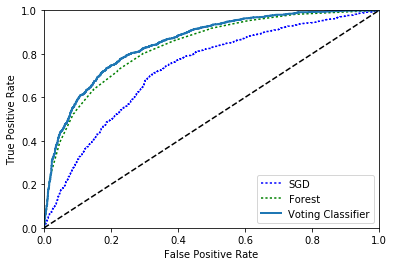

In [45]:
plt.plot(fpr,tpr,'b:',label='SGD')
plt.plot(fpr_forest, trp_forest,'g:',label='Forest')
plot_roc_curve(fpr_voting, trp_voting, 'Voting Classifier')
plt.legend(loc='lower right')
plt.show()

In [46]:
roc_auc_score(y_train, y_scores_voting)

0.8520157870260401

In [47]:
y_train_pred_voting = cross_val_predict(voting_clf_soft, X_train, y_train, cv=3)
precision_score(y_train, y_train_pred_voting)

0.7725612936880543

In [48]:
recall_score(y_train, y_train_pred_voting)

0.786510886882634

In [49]:
f1_score(y_train, y_train_pred_voting)

0.7794736842105263

# Test out maximizing precision

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, method='decision_function')

In [51]:
y_train_pred_90 = (y_scores > 300)

In [52]:
precision_score(y_train, y_train_pred_90), recall_score(y_train,y_train_pred_90)

(0.0, 0.0)

Not Worth

## TensorFlow for fun

In [53]:
import tensorflow as tf

In [54]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

from functools import partial

Quick aside on how to make a network:

1. Construct the layers as above

2. Define the cost function

3. Define the evaluation operations 

4. create a variable initializer 

5. create a Saver

6. Execution phase (entails its whole own set of steps)

In [55]:
reset_graph()

n_inputs = X_train.shape[1]
n_hidden1 = 300
n_hidden2 = 100
# n_hidden3 = 50 # testing out 
n_outputs = 2
batch_norm_momentum = 0.9
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')


with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)
# Part 1.
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    
#     hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
#     bn3 = tf.nn.elu(my_batch_norm_layer(hidden3))
    
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

# Part 2.
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
# Part 3.
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# Part 4.
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [56]:
## The execuation phase here is much the same, save for two exceptions:

## 1. During training whenever you run and operation that depends on the batch_normalization() layer, you need to set 
## the training placeholder = True 

## 2. the batch_normalization function creates a few operations that must be evaluated at each step during training 
## in order to update the moving averages 

## These operations are automatically added to the UPDATE_OPS collection, so we just need to get the list of operations in that 
## collection and run them at each training iteration 

# Part 6.
n_epochs = 40 # Seems to cap out at ~30 epochs
batch_size = 50 #Lower batch size seems to work better 

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            X_batch, y_batch = X_train[iteration:iteration+batch_size], y_train[iteration:iteration+batch_size]
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        if epoch%5 == 0 or epoch == n_epochs-1:
            print(epoch, "Test accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy 0.6589532
5 Test accuracy 0.7415978
10 Test accuracy 0.7151515
15 Test accuracy 0.7245179
20 Test accuracy 0.73498625
25 Test accuracy 0.7245179
30 Test accuracy 0.7355372
35 Test accuracy 0.73002756
39 Test accuracy 0.7063361


Hmm it does about that same as random forest...let's try adding dropout and NAG

In [57]:
reset_graph()

n_inputs = X_train.shape[1]
n_hidden1 = 1000 #300
n_hidden2 = 500 #100
n_hidden3 = 200 # testing out -- 50
n_hidden4 = 50 # testing out
n_outputs = 2
batch_norm_momentum = 0.9
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

## DROPOUT ## 
dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)


with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)
# Part 1.
    hidden1 = my_dense_layer(X_drop, n_hidden1, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1_drop))
    
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2_drop))
    
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    hidden3_drop = tf.layers.dropout(hidden3, dropout_rate, training=training)
    bn3 = tf.nn.elu(my_batch_norm_layer(hidden3))
    
#     hidden4 = my_dense_layer(bn3, n_hidden4, name="hidden4")
#     hidden4_drop = tf.layers.dropout(hidden4, dropout_rate, training=training)
#     bn4 = tf.nn.elu(my_batch_norm_layer(hidden3))
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

# Part 2.
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
# Part 3.
with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# Part 4.
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
n_epochs = 70 
batch_size = 50 #Lower batch size seems to work better -- 50 seems to be optimal here 

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            X_batch, y_batch = X_train[iteration:iteration+batch_size], y_train[iteration:iteration+batch_size]
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        if epoch%5 == 0 or epoch == n_epochs-1:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.68 Validation accuracy: 0.6380165
5 Batch accuracy: 0.72 Validation accuracy: 0.7013774
10 Batch accuracy: 0.7 Validation accuracy: 0.68705237
15 Batch accuracy: 0.74 Validation accuracy: 0.73002756
20 Batch accuracy: 0.72 Validation accuracy: 0.7090909
25 Batch accuracy: 0.78 Validation accuracy: 0.74104685
30 Batch accuracy: 0.7 Validation accuracy: 0.71294767
35 Batch accuracy: 0.7 Validation accuracy: 0.71294767
40 Batch accuracy: 0.72 Validation accuracy: 0.7201102
45 Batch accuracy: 0.74 Validation accuracy: 0.7217631
50 Batch accuracy: 0.74 Validation accuracy: 0.71790636
55 Batch accuracy: 0.78 Validation accuracy: 0.73112947
60 Batch accuracy: 0.74 Validation accuracy: 0.72892565
65 Batch accuracy: 0.74 Validation accuracy: 0.723416
69 Batch accuracy: 0.72 Validation accuracy: 0.72506887


Notes on the model: 

1. 3 layers with a batch size of 50 seems to get the best accuracy

2. Higher number of nodes per layer seems to get higher accuracy - but takes much longer to compute

3. No matter what setting I use I seem to cap out around 72-74% Tests Accuracy - worse than the logistic regression



## Financial Value

In [59]:
list(train_df)

['Choice',
 'A_follower_count',
 'A_following_count',
 'A_listed_count',
 'A_mentions_received',
 'A_retweets_received',
 'A_mentions_sent',
 'A_retweets_sent',
 'A_posts',
 'A_network_feature_1',
 'A_network_feature_2',
 'A_network_feature_3',
 'B_follower_count',
 'B_following_count',
 'B_listed_count',
 'B_mentions_received',
 'B_retweets_received',
 'B_mentions_sent',
 'B_retweets_sent',
 'B_posts',
 'B_network_feature_1',
 'B_network_feature_2',
 'B_network_feature_3']

In [75]:
fin_df = train_df[['Choice', 'A_follower_count', 'B_follower_count']].copy()
fin_df.head()

,Choice,A_follower_count,B_follower_count
0,0,228,34463
1,0,21591,39262
2,0,7310,3622
3,0,20,19562
4,1,45589,7554


In [76]:
## Make vectorized columns

# Make columns for determining if A inf. B or B inf. A
fin_df['A_inf_B'] = fin_df['Choice']
fin_df['B_inf_A'] = (fin_df['Choice']-1)*-1


# Column for probability 
fin_df['A_expected_buy_1tweet'] = fin_df['A_follower_count']*0.0005
fin_df['B_expected_buy_1tweet'] = fin_df['B_follower_count']*0.0005

# expected profit
fin_df['expected_profit_NA'] = (fin_df['A_expected_buy_1tweet']*fin_df['A_inf_B']) + (fin_df['B_expected_buy_1tweet']*fin_df['B_inf_A'])


fin_df.head()


,Choice,A_follower_count,B_follower_count,A_inf_B,B_inf_A,A_expected_buy_1tweet,B_expected_buy_1tweet,expected_profit_NA
0,0,228,34463,0,1,0.1140,17.2315,17.2315
1,0,21591,39262,0,1,10.7955,19.6310,19.6310
2,0,7310,3622,0,1,3.6550,1.8110,1.8110
3,0,20,19562,0,1,0.0100,9.7810,9.7810
4,1,45589,7554,1,0,22.7945,3.7770,22.7945


In [77]:
# Find total number of tweeters
num_tweeters = fin_df.shape[0]*2
num_tweeters

11000

In [78]:
# Calculate expected profit from total selection 
total_cost = num_tweeters*5
expected_buy = fin_df['expected_profit_NA'].sum()
expected_profit = expected_buy - total_cost
expected_profit

2633284.296499992

In [79]:
# Make new dataframe to get predictions on whole training set 
train2_df = train_df.copy()
train2_df = train2_df.drop(['Choice'], axis=1)
train2_target = train_df[['Choice']].copy()

In [80]:
# clf.fit(X_train, y_train)
y_pred = voting_clf_soft.predict(train2_df) # Get prediction probabilties 
print('voting_clf_soft', accuracy_score(train2_target, y_pred))
# voting_clf_soft.predict_proba(train2_df)
confusion_matrix(train2_target, y_pred)

voting_clf_soft 0.8698181818181818


array([[2310,  388],
       [ 328, 2474]], dtype=int64)

In [81]:
y_probas = cross_val_predict(voting_clf_soft, train2_df, train2_target, cv=3, method='predict_proba') # Get probabilities 
y_probas

array([[0.7016245 , 0.2983755 ],
       [0.40624329, 0.59375671],
       [0.42213424, 0.57786576],
       ...,
       [0.38128307, 0.61871693],
       [0.65322064, 0.34677936],
       [0.82778585, 0.17221415]])

In [82]:
# Add probabilities from model to dataframe
fin_df['prob_A_inf_B'] = y_probas[:,1]
fin_df['prob_B_inf_A'] = y_probas[:,0]
fin_df.head()

,Choice,A_follower_count,B_follower_count,A_inf_B,B_inf_A,A_expected_buy_1tweet,B_expected_buy_1tweet,expected_profit_NA,prob_A_inf_B,prob_B_inf_A
0,0,228,34463,0,1,0.1140,17.2315,17.2315,0.298376,0.701624
1,0,21591,39262,0,1,10.7955,19.6310,19.6310,0.593757,0.406243
2,0,7310,3622,0,1,3.6550,1.8110,1.8110,0.577866,0.422134
3,0,20,19562,0,1,0.0100,9.7810,9.7810,0.232977,0.767023
4,1,45589,7554,1,0,22.7945,3.7770,22.7945,0.578260,0.421740


In [83]:
# Add vectorized columns to substitute the hard voted probabilities 
fin_df['A_inf_B_model'] = ((fin_df['prob_A_inf_B'] - fin_df['prob_B_inf_A']) / 
                           (abs(fin_df['prob_A_inf_B'] - fin_df['prob_B_inf_A'])) + 1 ) / 2
fin_df['B_inf_A_model'] = (fin_df['A_inf_B_model'] - 1 )*-1

fin_df.head()

,Choice,A_follower_count,B_follower_count,A_inf_B,B_inf_A,A_expected_buy_1tweet,B_expected_buy_1tweet,expected_profit_NA,prob_A_inf_B,prob_B_inf_A,A_inf_B_model,B_inf_A_model
0,0,228,34463,0,1,0.1140,17.2315,17.2315,0.298376,0.701624,0.0,1.0
1,0,21591,39262,0,1,10.7955,19.6310,19.6310,0.593757,0.406243,1.0,-0.0
2,0,7310,3622,0,1,3.6550,1.8110,1.8110,0.577866,0.422134,1.0,-0.0
3,0,20,19562,0,1,0.0100,9.7810,9.7810,0.232977,0.767023,0.0,1.0
4,1,45589,7554,1,0,22.7945,3.7770,22.7945,0.578260,0.421740,1.0,-0.0


In [84]:
# Make columns for expected profit of tweeting twice 

fin_df['A_expected_buy_2tweets'] = fin_df['A_follower_count']*0.00075
fin_df['B_expected_buy_2tweets'] = fin_df['B_follower_count']*0.00075

In [85]:
# Create columns for overall expected profit for part II 
fin_df['expected_profit'] = (fin_df['A_inf_B_model']*fin_df['A_expected_buy_2tweets']*fin_df['A_inf_B']) + (fin_df['B_inf_A_model']*fin_df['B_expected_buy_2tweets']*fin_df['B_inf_A'])
fin_df.head()

,Choice,A_follower_count,B_follower_count,A_inf_B,B_inf_A,A_expected_buy_1tweet,B_expected_buy_1tweet,expected_profit_NA,prob_A_inf_B,prob_B_inf_A,A_inf_B_model,B_inf_A_model,A_expected_buy_2tweets,B_expected_buy_2tweets,expected_profit
0,0,228,34463,0,1,0.1140,17.2315,17.2315,0.298376,0.701624,0.0,1.0,0.17100,25.84725,25.84725
1,0,21591,39262,0,1,10.7955,19.6310,19.6310,0.593757,0.406243,1.0,-0.0,16.19325,29.44650,0.00000
2,0,7310,3622,0,1,3.6550,1.8110,1.8110,0.577866,0.422134,1.0,-0.0,5.48250,2.71650,0.00000
3,0,20,19562,0,1,0.0100,9.7810,9.7810,0.232977,0.767023,0.0,1.0,0.01500,14.67150,14.67150
4,1,45589,7554,1,0,22.7945,3.7770,22.7945,0.578260,0.421740,1.0,-0.0,34.19175,5.66550,34.19175


Need to check against if they are actually influencers - right now choosing everyone as an influencer

In [86]:
total_cost_wa = fin_df.shape[0]*10 # total cost = 1 person per row * $10 per person
expected_buy_wa = fin_df['expected_profit'].sum() # expected revenue is sum of the expected buy column
expected_profit_wa = expected_buy_wa - total_cost_wa # Calculate expected profit 
expected_profit_wa

3627270.0102500003

In [87]:
## perfect model 
fin_df['perfect_buy'] = (fin_df['A_inf_B'] * fin_df['A_expected_buy_2tweets']) + (fin_df['B_inf_A']*fin_df['B_expected_buy_2tweets'])
perfect_profit = fin_df['perfect_buy'].sum() - total_cost_wa
perfect_profit

3977426.444749994

In [88]:
fin_df.head()

,Choice,A_follower_count,B_follower_count,A_inf_B,B_inf_A,A_expected_buy_1tweet,B_expected_buy_1tweet,expected_profit_NA,prob_A_inf_B,prob_B_inf_A,A_inf_B_model,B_inf_A_model,A_expected_buy_2tweets,B_expected_buy_2tweets,expected_profit,perfect_buy
0,0,228,34463,0,1,0.1140,17.2315,17.2315,0.298376,0.701624,0.0,1.0,0.17100,25.84725,25.84725,25.84725
1,0,21591,39262,0,1,10.7955,19.6310,19.6310,0.593757,0.406243,1.0,-0.0,16.19325,29.44650,0.00000,29.44650
2,0,7310,3622,0,1,3.6550,1.8110,1.8110,0.577866,0.422134,1.0,-0.0,5.48250,2.71650,0.00000,2.71650
3,0,20,19562,0,1,0.0100,9.7810,9.7810,0.232977,0.767023,0.0,1.0,0.01500,14.67150,14.67150,14.67150
4,1,45589,7554,1,0,22.7945,3.7770,22.7945,0.578260,0.421740,1.0,-0.0,34.19175,5.66550,34.19175,34.19175
